In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 48.5 MB/s 


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense


from textblob import TextBlob
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [6]:
df = pd.read_csv('/content/amazon_reviews_sample.csv')

In [10]:
df.head()

,Unnamed: 0,review
0,0,Stuning even for the non-gamer: This sound tr...
1,1,The best soundtrack ever to anything.: I'm re...
2,2,Amazing!: This soundtrack is my favorite musi...
3,3,Excellent Soundtrack: I truly like this sound...
4,4,"Remember, Pull Your Jaw Off The Floor After H..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   review      10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [12]:
reviews = df.review

# Preprocessing

In [13]:
# tokenize the words
tokens = [word_tokenize(sent) for sent in reviews]

# Eliminate all special characters and numbers
tokens = [[word for word in item if word.isalpha()] for item in tokens]

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [[word for word in item if word not in stop_words]for item in tokens]



In [14]:
# Lemmatize the words
lemmatizer=WordNetLemmatizer()
cleaned_tokens = [[lemmatizer.lemmatize(word) for word in item] for item in tokens]

cleaned_tokens[0][:10]

['Stuning',
 'even',
 'This',
 'sound',
 'track',
 'beautiful',
 'It',
 'paint',
 'senery',
 'mind']

In [15]:
# Lower the words

cleaned_tokens = [[word.lower() for word in item] for item in cleaned_tokens]
cleaned_tokens[0][:10]

['stuning',
 'even',
 'this',
 'sound',
 'track',
 'beautiful',
 'it',
 'paint',
 'senery',
 'mind']

In [16]:
cleaned_tokens[:5]

[['stuning',
  'even',
  'this',
  'sound',
  'track',
  'beautiful',
  'it',
  'paint',
  'senery',
  'mind',
  'well',
  'i',
  'would',
  'recomend',
  'even',
  'people',
  'hate',
  'vid',
  'game',
  'music',
  'i',
  'played',
  'game',
  'chrono',
  'cross',
  'game',
  'i',
  'ever',
  'played',
  'best',
  'music',
  'it',
  'back',
  'away',
  'crude',
  'keyboarding',
  'take',
  'fresher',
  'step',
  'grate',
  'guitar',
  'soulful',
  'orchestra',
  'it',
  'would',
  'impress',
  'anyone',
  'care',
  'listen'],
 ['the',
  'best',
  'soundtrack',
  'ever',
  'anything',
  'i',
  'reading',
  'lot',
  'review',
  'saying',
  'best',
  'soundtrack',
  'i',
  'figured',
  'i',
  'write',
  'review',
  'disagree',
  'bit',
  'this',
  'opinino',
  'yasunori',
  'mitsuda',
  'ultimate',
  'masterpiece',
  'the',
  'music',
  'timeless',
  'i',
  'listening',
  'year',
  'beauty',
  'simply',
  'refuse',
  'price',
  'tag',
  'pretty',
  'staggering',
  'i',
  'must',
  'say'

In [17]:
# Join the words

reviews = [' '.join(item) for item in cleaned_tokens]
reviews[:1]

['stuning even this sound track beautiful it paint senery mind well i would recomend even people hate vid game music i played game chrono cross game i ever played best music it back away crude keyboarding take fresher step grate guitar soulful orchestra it would impress anyone care listen']

In [18]:
len(reviews)

10000

In [19]:
blob = TextBlob(reviews[0])
blob.sentiment

Sentiment(polarity=-0.045000000000000005, subjectivity=0.47999999999999987)

In [20]:
blob.sentiment[0]

-0.045000000000000005

In [21]:
# Calculate Polarity Score

sentiments = []
for review in reviews:
  blob = TextBlob(review)
  
  if blob.sentiment[0]>=0:
    sentiments.append(1)
  else:
    sentiments.append(0)

In [22]:
sentiments[:5]

[0, 1, 1, 1, 1]

In [23]:
data = {
    'review':reviews,
    'sentiment':sentiments
}

reviews_df = pd.DataFrame(data)
reviews_df.head()

,review,sentiment
0,stuning even this sound track beautiful it pai...,0
1,the best soundtrack ever anything i reading lo...,1
2,amazing this soundtrack favorite music time ha...,1
3,excellent soundtrack i truly like soundtrack i...,1
4,remember pull your jaw off the floor after hea...,1


In [24]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


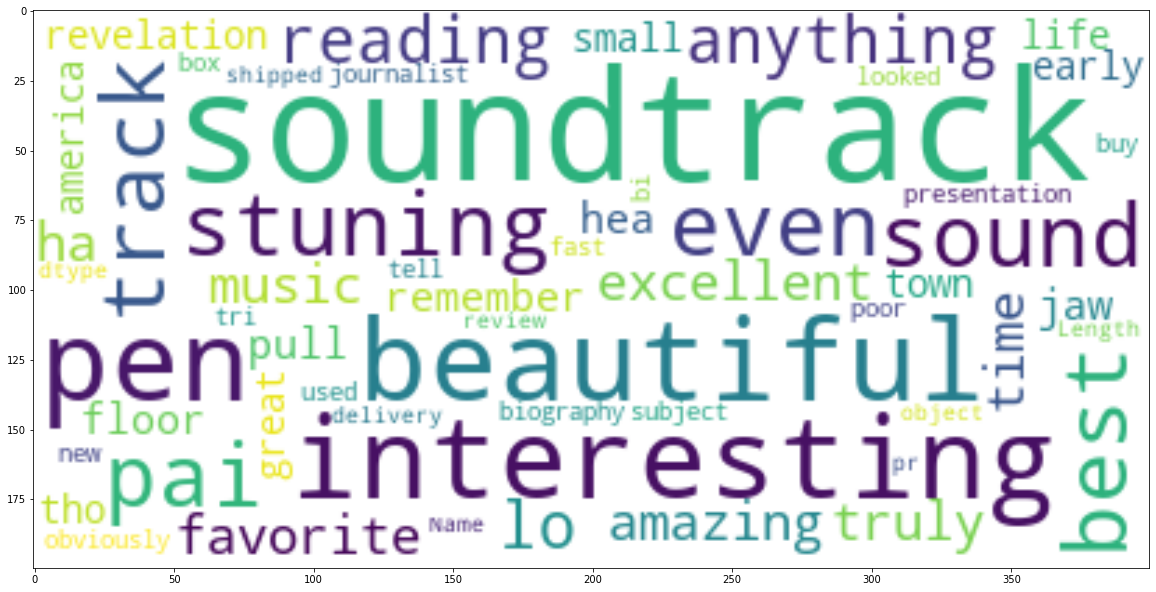

In [25]:
review_graph = WordCloud(background_color='white').generate(str(reviews_df.review))

plt.figure(figsize=(20,15))
plt.imshow(review_graph, interpolation='bilinear')
plt.show()

# Model Building using BERT

In [26]:
reviews_df['sentiment'].value_counts()

1    7513
0    2487
Name: sentiment, dtype: int64

# Split the Dataset

In [27]:
from sklearn.model_selection import train_test_split

X = reviews_df['review']
y = reviews_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3, random_state=1111)

# Import Bert

In [28]:
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [29]:
print(X_train.shape)
print(X_test.shape)

(7000,)
(3000,)


In [36]:
# pooled_output is the word embedding which is learnt through BERT

preprocessed_text_train = bert_preprocessor(X_train[:1000])
encoding_train = bert_encoder(preprocessed_text_train)['pooled_output']

preprocessed_text_test = bert_preprocessor(X_test[:300])
encoding_test = bert_encoder(preprocessed_text_test)['pooled_output']

In [37]:
encoding_train.shape

TensorShape([1000, 768])

In [73]:
preprocessed_text_train.keys()

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])

# Building the Neural Network

In [52]:
import time
train_enc = []
test_enc = []

for i in range(0,7000,1000):
  preprocessed_text = bert_preprocessor(X_train[i:i+1000])
  encoding = bert_encoder(preprocessed_text)['pooled_output']  
  train_enc.append(encoding)
  time.sleep(5)

for i in range(0,3000,1000):
  preprocessed_text = bert_preprocessor(X_test[i:i+1000])
  encoding = bert_encoder(preprocessed_text)['pooled_output'] 
  test_enc.append(encoding)
  time.sleep(5)

AttributeError: ignored

In [58]:
train_enc = np.array(train_enc)
train_enc.shape

(7, 1000, 768)

In [59]:
test_enc = np.array(test_enc)
test_enc.shape

(3, 1000, 768)

In [60]:
train_X = train_enc.reshape(7000,768)
test_X = test_enc.reshape(3000,768)

In [62]:
len(train_X[0])

768

In [63]:
model = Sequential()

model.add(Dense(300,activation='relu',input_shape=(768,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 300)               230700    
                                                                 
 dense_7 (Dense)             (None, 200)               60200     
                                                                 
 dense_8 (Dense)             (None, 100)               20100     
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 316,571
Trainable params: 316,571
Non-tr

In [65]:
hist = model.fit(train_X, y_train, validation_split=0.30, epochs=50, batch_size=10)

Epoch 1/50
490/490 [==============================] - 7s 11ms/step - loss: 0.5461 - accuracy: 0.7569 - val_loss: 0.5411 - val_accuracy: 0.7381
Epoch 2/50
490/490 [==============================] - 4s 9ms/step - loss: 0.5052 - accuracy: 0.7576 - val_loss: 0.5107 - val_accuracy: 0.7381
Epoch 3/50
490/490 [==============================] - 4s 8ms/step - loss: 0.4798 - accuracy: 0.7712 - val_loss: 0.4915 - val_accuracy: 0.7652
Epoch 4/50
490/490 [==============================] - 4s 8ms/step - loss: 0.4681 - accuracy: 0.7733 - val_loss: 0.5047 - val_accuracy: 0.7581
Epoch 5/50
490/490 [==============================] - 4s 9ms/step - loss: 0.4603 - accuracy: 0.7814 - val_loss: 0.4972 - val_accuracy: 0.7610
Epoch 6/50
490/490 [==============================] - 4s 9ms/step - loss: 0.4547 - accuracy: 0.7859 - val_loss: 0.4908 - val_accuracy: 0.7719
Epoch 7/50
490/490 [==============================] - 4s 8ms/step - loss: 0.4519 - accuracy: 0.7841 - val_loss: 0.4790 - val_accuracy: 0.7762
Epoch

In [66]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

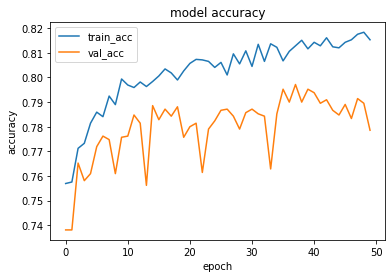

In [71]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

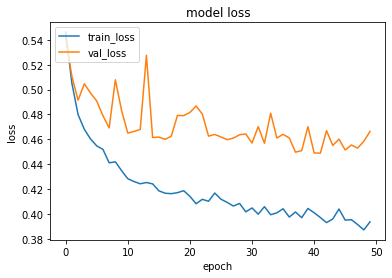

In [72]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [69]:
model.evaluate(test_X, y_test)

94/94 [==============================] - 1s 7ms/step - loss: 0.4296 - accuracy: 0.7940


[0.4296392500400543, 0.7940000295639038]

# Resources:

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://jalammar.github.io/illustrated-bert/
